In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from itertools import product

In [4]:
from commons import smoothen, lse

In [5]:
fontsize = 14

# Loading the data

## $N_i(t)$

In order to compute the $\rho_i(t)$ as to compare them with their predictions, we first load the $N_i(t)$, which we smoothen accordingly :

In [6]:
Nt = smoothen(np.load("curves_raw.npy"), 10)

## $\rho_i(t)$

We then first calculate the discrete derivatives $\frac{\Delta N_i(t)}{\Delta t} = \Delta N_i(t) = N_i(t+1) - N_i(t)$

In [7]:
dNdt = Nt[..., 1:] - Nt[..., :-1]

and then the $\rho_i(t) = \frac{\Delta N_i(t)}{N_i(t)}$

In [8]:
rho = dNdt / Nt[..., :-1]

## $\hat\rho_i(t)$

Then we load the predicted $\hat\rho_i(t)$ from the various models.

First the location-and-population-specific $\hat\rho_i(t) = \alpha_i(t) \; \epsilon_k(t)$ model :

In [9]:
aek = np.load("predictions/level-2_alpha-epsilon_k.npy")

Then the density-dependent $\hat\rho_i(t) = \alpha_i(t) \; \epsilon_k(t) \; \phi(N_i(t))$ model :

In [10]:
aep = np.load("predictions/level-2_alpha-epsilon_k-phi.npy")

Finally the diffusion model $\hat\rho_i(t) = \alpha_i(t) \; f(s(x_i, t))$ :

In [11]:
diff = np.load("predictions/level-3_diffusion.npy")

# Computations

## Dimensions

We get the dimensions of the data :

In [12]:
n_plates, n_rows, n_columns, n_points = rho.shape
plates, rows, columns, points = map(np.arange, rho.shape)

## Null model

We also compute here the null model $\hat\rho_i(t) = \epsilon(t) = \bar\rho(t)$ :

In [13]:
null = rho.reshape((n_plates, -1, n_points)).mean(axis = 1)

## Errors

We now compute the errors of each model by using the euclidean distance for each population $i$ along its time series :

In [14]:
_null = np.empty((n_plates, n_rows, n_columns))
_aek, _aep, _diff = _null.copy(), _null.copy(), _null.copy()

for p, r, c in product(plates, rows, columns):
    _null[p, r, c] = lse(rho[p, r, c], null[p])
    _aek[p, r, c] = lse(rho[p, r, c], aek[p, r, c])
    _aep[p, r, c] = lse(rho[p, r, c], aep[p, r, c])
    _diff[p, r, c] = lse(rho[p, r, c], diff[p, r+3, c+3])

# Figure

We group the error data and its names :

In [15]:
errors = (_null, _aek, _aep, _diff)
names = ("null model", r"$\alpha$ $\epsilon_k$ model", r"$\alpha$ $\epsilon_k$ $s$ model", "diffusion model")

Change the variable `p` in order to generate the figure for other plates

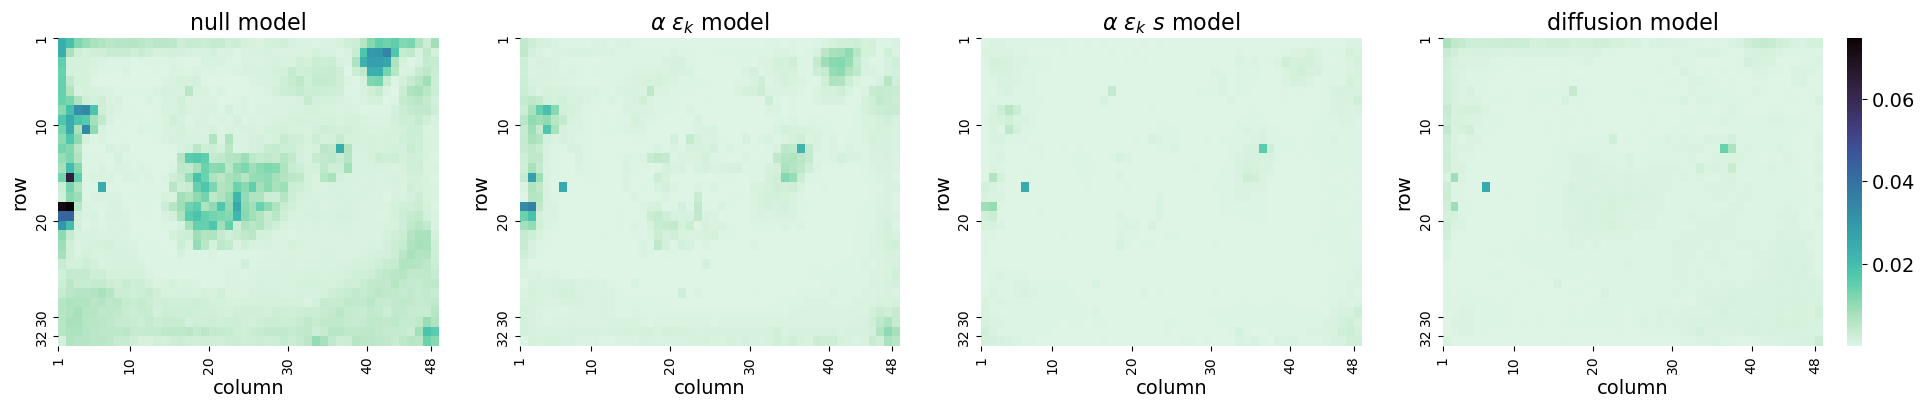

In [16]:
fig, axes = plt.subplots(ncols = len(errors), figsize = (24, 4), gridspec_kw = { "width_ratios": [1, 1, 1, 1.25] })

p = 0

_max = max( err[p].max() for err in errors )
cmap = sns.color_palette("mako_r", as_cmap = True)
for i, (err, ax) in enumerate(zip(errors, axes)):
    sns.heatmap(err[p], ax = ax, cmap = cmap, vmax = _max, cbar = (i == len(errors)-1))
    xticks = [0] + list(range(9, n_columns, 10)) + [n_columns-1]
    yticks = [0] + list(range(9, n_rows, 10)) + [n_rows-1]
    ax.set_xticks(xticks, np.array(xticks) + 1)
    ax.set_yticks(yticks, np.array(yticks) + 1)
    if p == 0:
        ax.set_title(names[i], fontsize = fontsize+2)
    ax.set_ylabel("row", fontsize = fontsize)
    ax.set_xlabel("column", fontsize = fontsize)

axes[-1].collections[0].colorbar.ax.tick_params(labelsize = fontsize)

fig.savefig(f"plots/figure-3/spatial_plate-{p+1}.pdf", bbox_inches = "tight")
fig.savefig(f"plots/figure-3/spatial_plate-{p+1}.png", bbox_inches = "tight")